In [3]:
DATA_DIR = '../data/1000g'

In [18]:
import pandas as pd
import subprocess
import os
from typing import Dict, Set, List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

In [56]:
def get_hapmap_positions(hapmap_file: str) -> Dict[int, Set[str]]:
    """Read HapMap3 SNP positions by chromosome"""
    print("Reading HapMap3 positions...")
    hapmap_df = pd.read_csv(hapmap_file, sep='\s+', header=None,
                           names=['SNP', 'chromosome', 'morgans', 'position', 'ref', 'alt'])
    
    positions_by_chr = {}
    for chrom in range(1, 23):
        chr_data = hapmap_df[hapmap_df['chromosome'] == chrom]
        positions_by_chr[chrom] = set(f"{chrom}:{pos}" for pos in chr_data['position'])
    
    return positions_by_chr

def get_1000g_positions(vcf_file: str) -> Set[str]:
    """Extract SNP positions from VCF file"""
    cmd = f"bcftools query -f '%CHROM:%POS\n' {vcf_file}"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    return set(result.stdout.strip().split('\n'))

def filter_vcf_by_positions(input_vcf: str, output_vcf: str, positions: Set[str]):
    """Filter VCF file to keep only specified positions"""
    # Create temporary positions file
    temp_pos_file = f"temp_positions_{os.path.basename(input_vcf)}.txt"
    with open(temp_pos_file, 'w') as f:
        for pos in positions:
            chrom, pos = pos.split(':')
            f.write(f"{chrom}\t{pos}\n")
    
    # Filter VCF
    cmd = f'bcftools view -T {temp_pos_file} -Oz -o {output_vcf} {input_vcf}'
    subprocess.run(cmd, shell=True, check=True)
    
    # Index filtered file
    subprocess.run(f'bcftools index {output_vcf}', shell=True, check=True)
    
    # Remove temporary file
    os.remove(temp_pos_file)

def process_chromosome(chrom: int, hapmap_positions: Set[str], 
                      data_dir: str, output_dir: str) -> Tuple[int, Dict]:
    """Process a single chromosome to find and filter common SNPs"""
    try:
        # Input files
        vcf_file = os.path.join(data_dir, f'filtered.chr{chrom}.phase3.vcf.gz')
        
        # Get 1000G positions
        kg_positions = get_1000g_positions(vcf_file)
        
        # Find common positions
        common_positions = hapmap_positions.intersection(kg_positions)
        
        # Create output directory if needed
        os.makedirs(output_dir, exist_ok=True)
        
        # Filter VCF file
        output_vcf = os.path.join(output_dir, f'common_snps.chr{chrom}.vcf.gz')
        filter_vcf_by_positions(vcf_file, output_vcf, common_positions)
        
        stats = {
            'chromosome': chrom,
            'hapmap_count': len(hapmap_positions),
            'kg_count': len(kg_positions),
            'common_count': len(common_positions)
        }
        
        return chrom, stats
        
    except Exception as e:
        print(f"Error processing chromosome {chrom}: {e}")
        return chrom, None

def main():
    # Configuration
    DATA_DIR = '../data/1000g'
    OUTPUT_DIR = '../data/common_snps'
    HAPMAP_FILE = '/Users/jingl1/Desktop/CMU/02704/hw_data/02704_data/HapMap3.snp'  # Update with your HapMap3 file path
    
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Get HapMap positions by chromosome
    hapmap_positions = get_hapmap_positions(HAPMAP_FILE)
    
    # Process all chromosomes
    stats_all = []
    with ThreadPoolExecutor(max_workers=3) as executor:
        future_to_chrom = {}
        for chrom in range(1, 23):
            future = executor.submit(
                process_chromosome,
                chrom,
                hapmap_positions[chrom],
                DATA_DIR,
                OUTPUT_DIR
            )
            future_to_chrom[future] = chrom
        
        for future in tqdm(as_completed(future_to_chrom), total=22):
            chrom = future_to_chrom[future]
            _, stats = future.result()
            if stats:
                stats_all.append(stats)
    
    # Create summary
    stats_df = pd.DataFrame(stats_all)
    stats_df['hapmap_pct'] = (stats_df['common_count'] / stats_df['hapmap_count'] * 100).round(2)
    stats_df['kg_pct'] = (stats_df['common_count'] / stats_df['kg_count'] * 100).round(2)
    
    # Save summary
    summary_file = os.path.join(OUTPUT_DIR, 'common_snps_summary.csv')
    stats_df.to_csv(summary_file, index=False)
    
    # Print summary
    print("\nSummary of common SNPs:")
    print(f"Total HapMap SNPs: {stats_df['hapmap_count'].sum():,}")
    print(f"Total 1000G SNPs: {stats_df['kg_count'].sum():,}")
    print(f"Total common SNPs: {stats_df['common_count'].sum():,}")
    print(f"\nDetailed statistics saved to: {summary_file}")

if __name__ == "__main__":
    main()

Reading HapMap3 positions...


100%|███████████████████████████████████████████| 22/22 [07:12<00:00, 19.65s/it]


Summary of common SNPs:
Total HapMap SNPs: 697,393
Total 1000G SNPs: 81,192,381
Total common SNPs: 21,643

Detailed statistics saved to: ../data/common_snps/common_snps_summary.csv


In [10]:
class MAFFilter:
    def __init__(self, data_dir='../data/1000g', output_dir=None):
        self.data_dir = data_dir
        self.output_dir = output_dir or os.path.join(data_dir, 'maf_filtered')
        os.makedirs(self.output_dir, exist_ok=True)
    
    def calculate_maf(self, vcf_file: str, output_file: str):
        """Calculate MAF for each variant and filter those with MAF < 5%"""
        print(f"Processing {vcf_file}")
        
        # Calculate allele frequencies using bcftools
        cmd = (f"bcftools +fill-tags {vcf_file} -- -t AF,MAF | "
               f"bcftools view -i 'MAF >= 0.05' -Oz -o {output_file}")
        
        print("Filtering variants with MAF < 5%...")
        subprocess.run(cmd, shell=True, check=True)
        
        # Index the filtered file
        subprocess.run(f"bcftools index {output_file}", shell=True, check=True)
        
        # Get statistics
        stats_cmd = f"bcftools stats {output_file}"
        stats = subprocess.run(stats_cmd, shell=True, capture_output=True, text=True).stdout
        
        return output_file, stats
    
    def filter_all_chromosomes(self):
        """Filter all chromosomes"""
        results = []
        
        for chrom in range(1, 23):
            input_vcf = os.path.join(self.data_dir, 
                                   f'filtered.chr{chrom}.phase3.vcf.gz')
            output_vcf = os.path.join(self.output_dir, 
                                    f'maf_filtered.chr{chrom}.phase3.vcf.gz')
            
            if not os.path.exists(input_vcf):
                print(f"Warning: Input file not found: {input_vcf}")
                continue
            
            # Calculate MAF and filter
            filtered_file, stats = self.calculate_maf(input_vcf, output_vcf)
            
            # Extract key statistics
            variant_counts = {}
            for line in stats.split('\n'):
                if line.startswith('SN'):
                    if 'number of records:' in line:
                        variant_counts['total'] = int(line.split()[-1])
            
            results.append({
                'chromosome': chrom,
                'filtered_variants': variant_counts.get('total', 0),
                'output_file': filtered_file
            })
        
        # Create summary
        summary_df = pd.DataFrame(results)
        summary_file = os.path.join(self.output_dir, 'maf_filtering_summary.csv')
        summary_df.to_csv(summary_file, index=False)
        
        print("\nMAF Filtering Summary:")
        print(summary_df)
        print(f"\nTotal variants after filtering: {summary_df['filtered_variants'].sum():,}")
        print(f"\nDetailed summary saved to: {summary_file}")
        
        return summary_df

def main():
    # Initialize filter
    maf_filter = MAFFilter()
    
    # Run filtering
    print("Starting MAF filtering for all chromosomes...")
    summary = maf_filter.filter_all_chromosomes()
    
    print("\nFiltering complete!")
    print("Filtered VCF files are saved in:", maf_filter.output_dir)

if __name__ == "__main__":
    main()

Starting MAF filtering for all chromosomes...
Processing ../data/1000g/filtered.chr1.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr2.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr3.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr4.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr5.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr6.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr7.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr8.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr9.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr10.phase3.vcf.gz
Filtering variants with MAF < 5%...
Processing ../data/1000g/filtered.chr11.phase3.vcf.gz
Filtering

In [7]:
# This is wrong, after checking the paper

def read_1000g_sites_from_txt(result_file, maf_threshold=0.05):
    """
    Read SNP information from the pre-processed result.txt file
    Filter by MAF threshold
    """
    print("Reading 1000G sites from result.txt...")
    
    # Read the pre-processed file
    df_1000g = pd.read_csv(result_file, sep='\t',
                          names=['chromosome', 'position', 'rsid', 'ref', 'alt', 'af'])
    
    print(f"Total SNPs before filtering: {len(df_1000g)}")
    
    # Filter out non-autosomal chromosomes
    df_1000g = df_1000g[df_1000g['chromosome'].astype(str).str.match('^\d+$')]
    df_1000g['chromosome'] = df_1000g['chromosome'].astype(int)
    df_1000g = df_1000g[df_1000g['chromosome'] <= 22]
    
    print(f"SNPs after filtering non-autosomal: {len(df_1000g)}")
    
    # Filter for biallelic SNPs (single base changes)
    df_1000g = df_1000g[~df_1000g['alt'].str.contains(',')]  # Remove multiallelic sites
    df_1000g = df_1000g[df_1000g['ref'].str.len() == 1]      # Keep only single-base reference
    df_1000g = df_1000g[df_1000g['alt'].str.len() == 1]      # Keep only single-base alternate
    
    print(f"SNPs after filtering multiallelic sites: {len(df_1000g)}")
    
    # Calculate MAF
    df_1000g['af'] = df_1000g['af'].astype(float)
    df_1000g['maf'] = df_1000g['af'].apply(lambda x: min(x, 1-x))
    
    # Filter by MAF
    df_1000g = df_1000g[df_1000g['maf'] >= maf_threshold]
    
    print(f"SNPs after MAF filtering (MAF >= {maf_threshold}): {len(df_1000g)}")
    return df_1000g

def find_common_snps(result_file='../data/1000g/result.txt', maf_threshold=0.05):
    """Find common SNPs between HapMap3 and 1000G"""
    # Load HapMap3 SNPs
    print("Loading HapMap3 SNPs...")
    hapmap_snps = read_snp_pop('HapMap3')
    hapmap_snps = hapmap_snps[hapmap_snps['chromosome'] <= 22]  # Keep only autosomes
    print(f"Total HapMap3 SNPs (autosomes): {len(hapmap_snps)}")
    
    # Load and filter 1000G SNPs
    print("\nLoading and filtering 1000G SNPs...")
    kg_snps = read_1000g_sites_from_txt(result_file, maf_threshold)
    
    # Find common SNPs based on chromosome and position
    print("\nFinding common SNPs...")
    common_snps = pd.merge(hapmap_snps, kg_snps,
                          on=['chromosome', 'position'],
                          suffixes=('_hapmap', '_1000g'))
    
    print(f"\nCommon SNPs found: {len(common_snps)}")
    
    # Check allele alignment
    common_snps['aligned'] = ((common_snps['ref_hapmap'] == common_snps['ref_1000g']) & 
                             (common_snps['alt_hapmap'] == common_snps['alt_1000g']))
    
    print(f"Directly aligned SNPs: {sum(common_snps['aligned'])} ({sum(common_snps['aligned'])/len(common_snps)*100:.1f}%)")
    
    # Basic statistics by chromosome
    print("\nSNPs by chromosome:")
    chr_stats = common_snps.groupby('chromosome').agg({
        'position': 'count',
        'aligned': 'sum'
    }).rename(columns={'position': 'total_snps', 'aligned': 'aligned_snps'})
    
    chr_stats['alignment_rate'] = (chr_stats['aligned_snps'] / chr_stats['total_snps'] * 100).round(1)
    print(chr_stats)
    
    # Save results
    output_file = f'common_snps_maf{maf_threshold}.csv'
    common_snps.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")
    
    return common_snps, chr_stats

# Run the analysis with MAF threshold of 0.05
common_snps, chr_stats = find_common_snps(result_file='../data/1000g/result.txt', maf_threshold=0.05)

# Save chromosome statistics
chr_stats.to_csv('chr_stats_maf0.05.csv')

# Display MAF distribution summary for common SNPs
print("\nMAF distribution in common SNPs:")
print(common_snps['maf'].describe())

Loading HapMap3 SNPs...
Total HapMap3 SNPs (autosomes): 699093

Loading and filtering 1000G SNPs...
Reading 1000G sites from result.txt...


/var/folders/96/2s64979965l0x1hmvz6rctxh0000gp/T/ipykernel_51798/583448108.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1000g = pd.read_csv(result_file, sep='\t',


Total SNPs before filtering: 84801880
SNPs after filtering non-autosomal: 81271745
SNPs after filtering multiallelic sites: 77818345
SNPs after MAF filtering (MAF >= 0.05): 6864701

Finding common SNPs...

Common SNPs found: 2037
Directly aligned SNPs: 294 (14.4%)

SNPs by chromosome:
            total_snps  aligned_snps  alignment_rate
chromosome                                          
1                  143            19            13.3
2                  159            20            12.6
3                  116            14            12.1
4                  116            11             9.5
5                  126            14            11.1
6                  152            24            15.8
7                  115            18            15.7
8                  112            13            11.6
9                  100            11            11.0
10                 100            16            16.0
11                  88            15            17.0
12                 110   

## RUN local:

for chr in {1..22}; do

  bcftools annotate \
    -a All_20180418.vcf.gz \
    -c ID \
    -o annotated/maf_filtered.chr${chr}.phase3.rsid.vcf.gz \
    -O z \
    maf_filtered/maf_filtered.chr${chr}.phase3.vcf.gz

bcftools index annotated/maf_filtered.chr${chr}.phase3.rsid.vcf.gz
done


In [11]:
import pandas as pd
import numpy as np
from CB_02704 import *
import gzip
from pathlib import Path
import os

def read_1000g_snps(vcf_file):
    """Read SNP IDs from 1000G VCF file"""
    snp_ids = set()
    with gzip.open(vcf_file, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.split('\t')
            rsid = fields[2]
            if rsid.startswith('rs'):
                snp_ids.add(rsid)
    return snp_ids

def process_chromosome(chr_num, kg_path, hapmap_snps):
    """Process one chromosome and find common SNPs"""
    # Construct 1000G file path
    kg_file = os.path.join(kg_path, f'maf_filtered.chr{chr_num}.phase3.rsid.vcf.gz')
    
    print(f"\nProcessing chromosome {chr_num}...")
    
    # Get HapMap SNPs for this chromosome
    hapmap_chr_snps = set(hapmap_snps[hapmap_snps['chromosome'] == chr_num].index)
    print(f"HapMap SNPs on chr{chr_num}: {len(hapmap_chr_snps)}")
    
    # Get 1000G SNPs
    kg_chr_snps = read_1000g_snps(kg_file)
    print(f"1000G SNPs on chr{chr_num}: {len(kg_chr_snps)}")
    
    # Find common SNPs
    common_snps = hapmap_chr_snps.intersection(kg_chr_snps)
    print(f"Common SNPs on chr{chr_num}: {len(common_snps)}")
    
    return list(common_snps)

def main():
    # Paths
    kg_path = "../data/1000g/annotated"
    
    # Read HapMap SNPs
    print("Reading HapMap SNPs...")
    hapmap_snps = read_snp_pop("HapMap3")
    
    # Process each chromosome
    all_common_snps = {}
    total_common = 0
    
    for chr_num in range(1, 23):
        common_snps = process_chromosome(chr_num, kg_path, hapmap_snps)
        all_common_snps[chr_num] = common_snps
        total_common += len(common_snps)
    
    print(f"\nTotal common SNPs across all chromosomes: {total_common}")
    
    # Save results
    output_dir = "common_snps"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save as both text files and pickle
    for chr_num, snps in all_common_snps.items():
        # Text file
        with open(f"{output_dir}/chr{chr_num}_common_snps.txt", 'w') as f:
            f.write('\n'.join(snps))
    
    # Save summary
    with open(f"{output_dir}/summary.txt", 'w') as f:
        f.write("Chromosome\tCommon SNPs\n")
        for chr_num in range(1, 23):
            f.write(f"{chr_num}\t{len(all_common_snps[chr_num])}\n")
        f.write(f"Total\t{total_common}\n")
    
    return all_common_snps

if __name__ == "__main__":
    common_snps = main()

Reading HapMap SNPs...

Processing chromosome 1...
HapMap SNPs on chr1: 55983
1000G SNPs on chr1: 15019
Common SNPs on chr1: 26

Processing chromosome 2...
HapMap SNPs on chr2: 58409
1000G SNPs on chr2: 19027
Common SNPs on chr2: 274

Processing chromosome 3...
HapMap SNPs on chr3: 48655
1000G SNPs on chr3: 14076
Common SNPs on chr3: 20

Processing chromosome 4...
HapMap SNPs on chr4: 43809
1000G SNPs on chr4: 14539
Common SNPs on chr4: 19

Processing chromosome 5...
HapMap SNPs on chr5: 45045
1000G SNPs on chr5: 12356
Common SNPs on chr5: 24

Processing chromosome 6...
HapMap SNPs on chr6: 46016
1000G SNPs on chr6: 15624
Common SNPs on chr6: 255

Processing chromosome 7...
HapMap SNPs on chr7: 38578
1000G SNPs on chr7: 13072
Common SNPs on chr7: 76

Processing chromosome 8...
HapMap SNPs on chr8: 38291
1000G SNPs on chr8: 11726
Common SNPs on chr8: 28

Processing chromosome 9...
HapMap SNPs on chr9: 32252
1000G SNPs on chr9: 62126
Common SNPs on chr9: 5216

Processing chromosome 10...


Key Findings:
Total common SNPs: 21,643
Average common SNPs per chromosome: 983.8
Chromosome with most common SNPs: 2 (1,784 SNPs)
Chromosome with least common SNPs: 22 (286 SNPs)
Average percentage in HapMap: 3.11%
Average percentage in 1000G: 0.03%


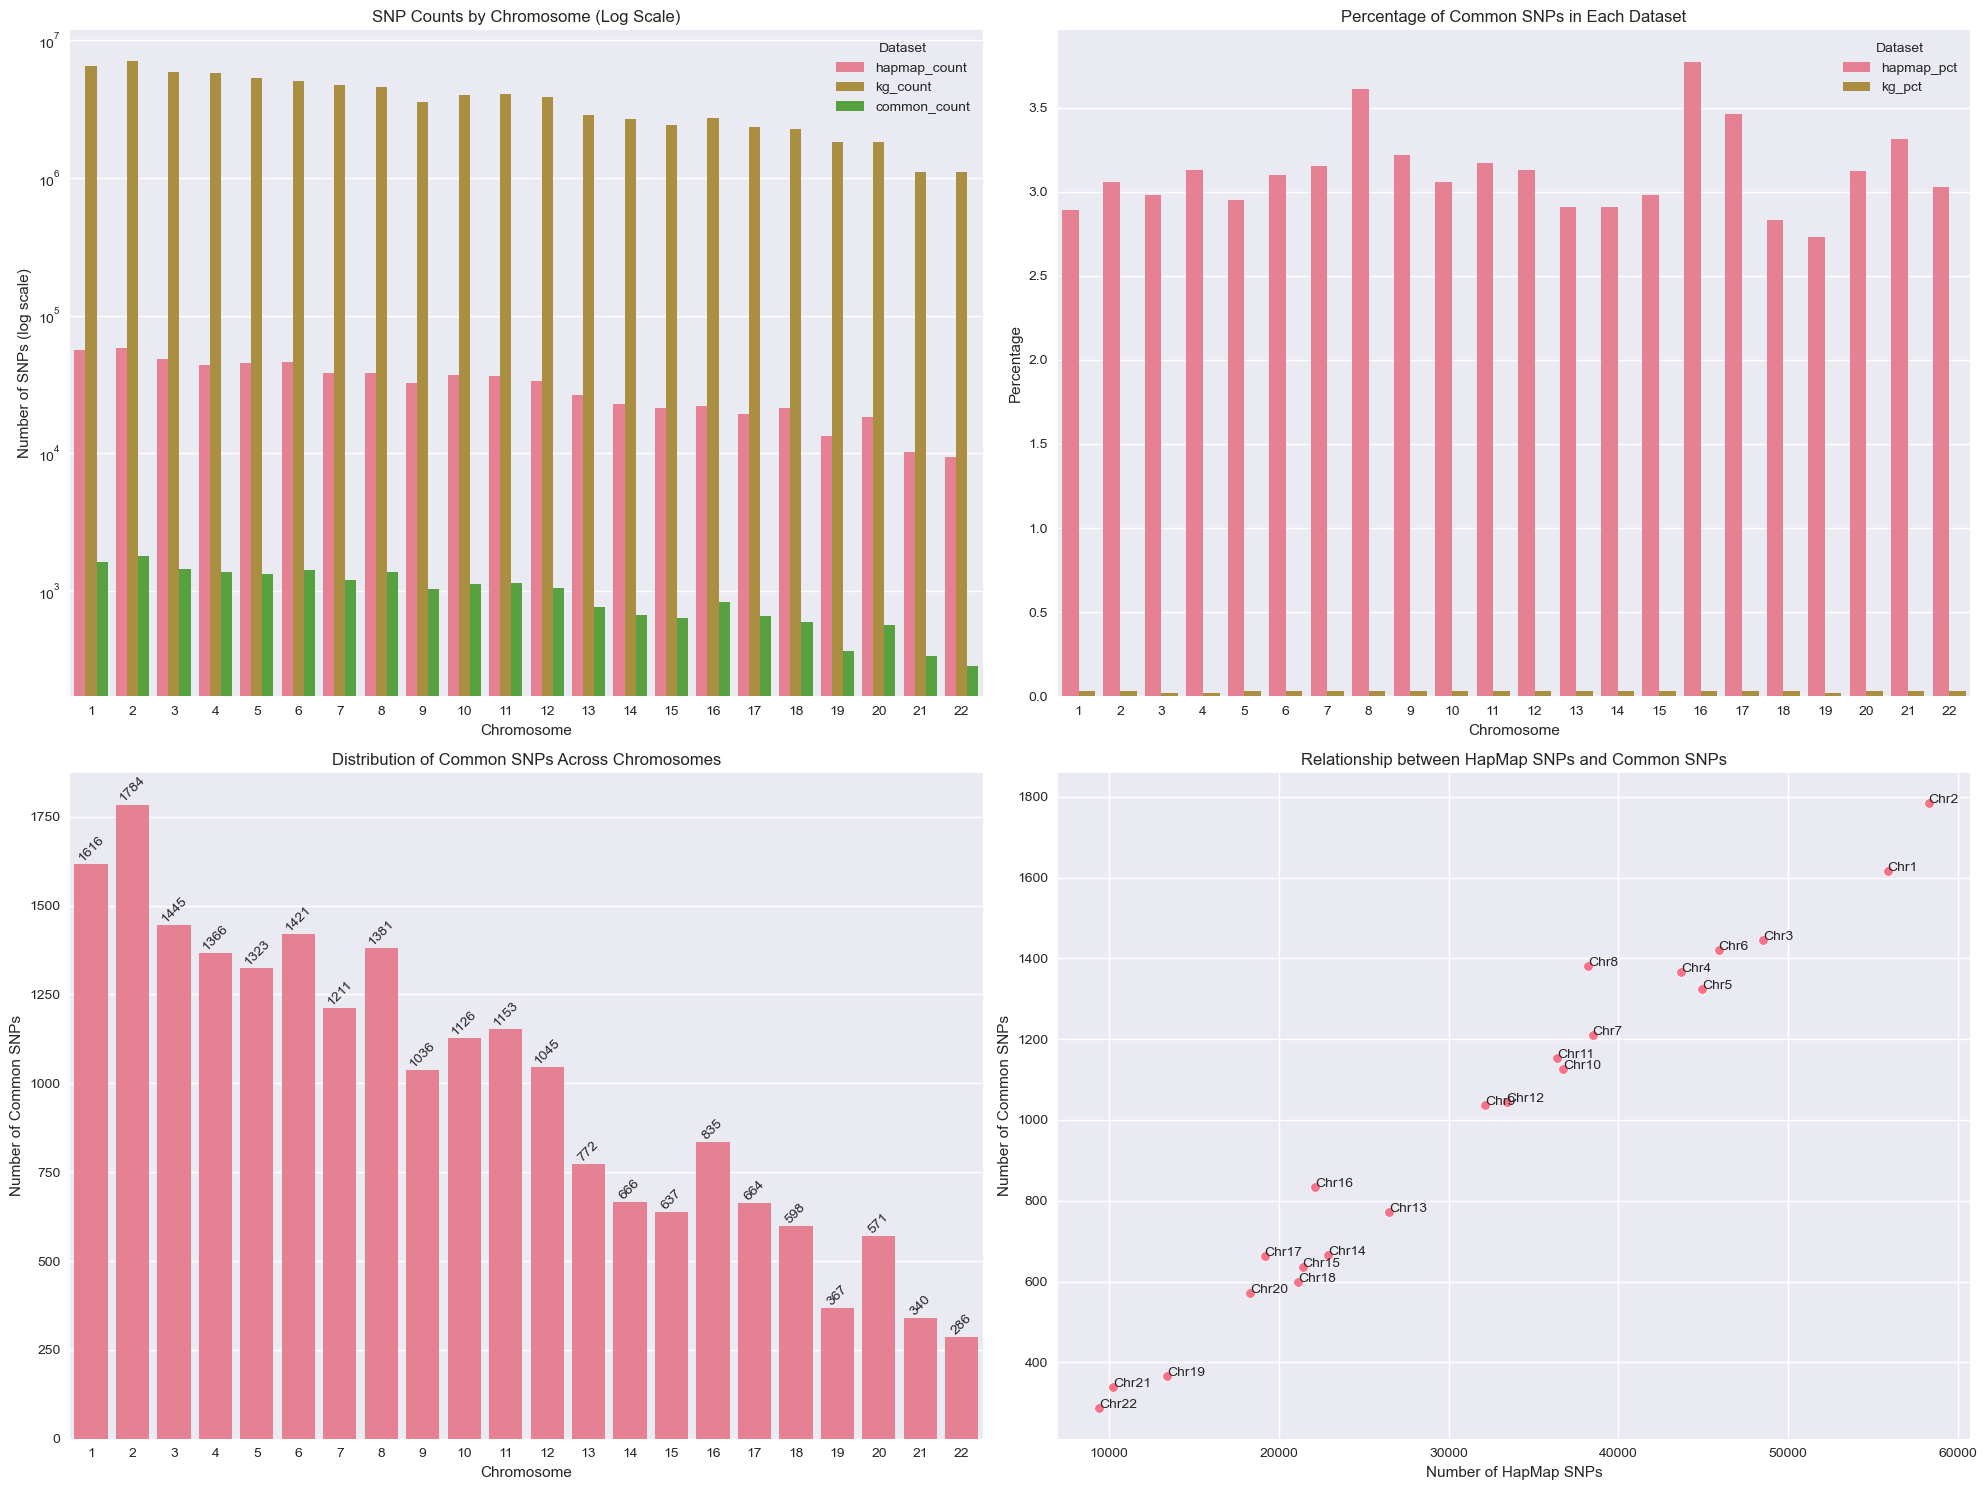

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
df = pd.read_csv('../data/common_snps/common_snps_summary.csv')

# Sort chromosomes numerically
df['chromosome'] = pd.to_numeric(df['chromosome'])
df = df.sort_values('chromosome')

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Bar plot comparing SNP counts across datasets
plt.subplot(2, 2, 1)
df_melted = df.melt(id_vars=['chromosome'], 
                    value_vars=['hapmap_count', 'kg_count', 'common_count'],
                    var_name='Dataset', value_name='Count')
# Use log scale due to large differences
plt.yscale('log')
sns.barplot(data=df_melted, x='chromosome', y='Count', hue='Dataset')
plt.title('SNP Counts by Chromosome (Log Scale)')
plt.xlabel('Chromosome')
plt.ylabel('Number of SNPs (log scale)')
plt.xticks(rotation=0)
plt.legend(title='Dataset')

# 2. Percentage comparison plot
plt.subplot(2, 2, 2)
df_pct = df.melt(id_vars=['chromosome'], 
                 value_vars=['hapmap_pct', 'kg_pct'],
                 var_name='Dataset', value_name='Percentage')
sns.barplot(data=df_pct, x='chromosome', y='Percentage', hue='Dataset')
plt.title('Percentage of Common SNPs in Each Dataset')
plt.xlabel('Chromosome')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Dataset')

# 3. Common SNPs distribution
plt.subplot(2, 2, 3)
sns.barplot(data=df, x='chromosome', y='common_count')
plt.title('Distribution of Common SNPs Across Chromosomes')
plt.xlabel('Chromosome')
plt.ylabel('Number of Common SNPs')
# Add value labels
for i, v in enumerate(df['common_count']):
    plt.text(i, v, str(v), ha='center', va='bottom', rotation=45)
plt.xticks(rotation=0)

# 4. Scatter plot: Chromosome Length vs Common SNPs
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='hapmap_count', y='common_count')
plt.title('Relationship between HapMap SNPs and Common SNPs')
plt.xlabel('Number of HapMap SNPs')
plt.ylabel('Number of Common SNPs')
# Add chromosome labels to points
for i, row in df.iterrows():
    plt.annotate(f"Chr{int(row['chromosome'])}", 
                (row['hapmap_count'], row['common_count']))

# Adjust layout and save
plt.tight_layout()
plt.savefig('snp_analysis.png', dpi=300, bbox_inches='tight')

# Create a summary statistics table
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Common SNPs',
        'Average Common SNPs per Chromosome',
        'Max Common SNPs (Chromosome)',
        'Min Common SNPs (Chromosome)',
        'Median Common SNPs',
        'Average HapMap Percentage',
        'Average 1000G Percentage'
    ],
    'Value': [
        f"{df['common_count'].sum():,}",
        f"{df['common_count'].mean():.1f}",
        f"{df['common_count'].max():,} (Chr{df.loc[df['common_count'].idxmax(), 'chromosome']})",
        f"{df['common_count'].min():,} (Chr{df.loc[df['common_count'].idxmin(), 'chromosome']})",
        f"{df['common_count'].median():.1f}",
        f"{df['hapmap_pct'].mean():.2f}%",
        f"{df['kg_pct'].mean():.2f}%"
    ]
})

# Save statistics
summary_stats.to_csv('snp_summary_stats.csv', index=False)

# Print key findings
print("\nKey Findings:")
print(f"Total common SNPs: {df['common_count'].sum():,}")
print(f"Average common SNPs per chromosome: {df['common_count'].mean():.1f}")
print(f"Chromosome with most common SNPs: {df.loc[df['common_count'].idxmax(), 'chromosome']} ({df['common_count'].max():,} SNPs)")
print(f"Chromosome with least common SNPs: {df.loc[df['common_count'].idxmin(), 'chromosome']} ({df['common_count'].min():,} SNPs)")
print(f"Average percentage in HapMap: {df['hapmap_pct'].mean():.2f}%")
print(f"Average percentage in 1000G: {df['kg_pct'].mean():.2f}%")